# Structural Simulation Exercise
Click the ▷ button below to setup the exercise's environment (will take about 2 mins).


In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment

import os
import pathlib
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     --channel conda-forge \
                     iverilog \
                     verilator
!python -m pip install numpy
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


In [ ]:
#@title Click the ▷ button to setup testbench
#@markdown The testbench allows us to check your work. No need to pay attention to this for now.

%%writefile tb_alu.v

module tb_alu;
    // Parameters
    parameter CLK_PERIOD = 10;

    // DUT signals
    reg [3:0] a, b;
    reg [2:0] opcode;
    wire [3:0] result;
    wire zero;

    // Clock for timing (not used by DUT but useful for waveforms)
    reg clk;
    initial clk = 0;
    always #(CLK_PERIOD/2) clk = ~clk;

    // Instantiate DUT
    ALU dut (
        .a(a),
        .b(b),
        .opcode(opcode),
        .result(result),
        .zero(zero)
    );

    // Test counters
    integer test_count;
    integer pass_count;
    integer fail_count;

    // Operation name (ASCII string stored in reg array)
    reg [256*8-1:0] operation_name;

    // Test task
    task test_operation;
        input [3:0] test_a;
        input [3:0] test_b;
        input [2:0] test_opcode;
        input [3:0] expected_result;
        input expected_cout;
        input expected_zero;
        input [256*8-1:0] op_name;
    begin
        test_count = test_count + 1;

        // Apply inputs
        a = test_a;
        b = test_b;
        opcode = test_opcode;
        operation_name = op_name;

        // Wait for combinational logic to settle
        #1;

        // Check results
        if (result === expected_result && zero === expected_zero) begin
            $display("PASS: %s | a=%b, b=%b, opcode=%b | result=%b, zero=%b",
                    operation_name, test_a, test_b, test_opcode, result, zero);
            pass_count = pass_count + 1;
        end else begin
            $display("FAIL: %s | a=%b, b=%b, opcode=%b",
                    operation_name, test_a, test_b, test_opcode);
            $display("     Expected: result=%b, zero=%b",
                    expected_result, expected_zero);
            $display("     Got:      result=%b, zero=%b",
                    result, zero);
            fail_count = fail_count + 1;
        end
    end
    endtask

    initial begin
        $display("=== ALU Structural Testbench ===");

        // Initialize
        a = 0; b = 0; opcode = 0;
        test_count = 0; pass_count = 0; fail_count = 0;
        #10;

        $display("--- Arithmetic Operations ---");
        // ADD (opcode 000)
        test_operation(4'b0001, 4'b0010, 3'b000, 4'b0011, 1'b0, 1'b0, "ADD: 1+2");
        test_operation(4'b1111, 4'b0001, 3'b000, 4'b0000, 1'b1, 1'b1, "ADD: 15+1 (overflow)");

        // SUB (opcode 001)
        test_operation(4'b0101, 4'b0010, 3'b001, 4'b0011, 1'b0, 1'b0, "SUB: 5-2");
        test_operation(4'b0000, 4'b0001, 3'b001, 4'b1111, 1'b1, 1'b0, "SUB: 0-1 (underflow)");

        $display("--- Logical Operations ---");
        // AND (opcode 010)
        test_operation(4'b1100, 4'b1010, 3'b010, 4'b1000, 1'b0, 1'b0, "AND: 1100 & 1010");
        test_operation(4'b1111, 4'b0000, 3'b010, 4'b0000, 1'b0, 1'b1, "AND: 1111 & 0000");

        // XOR (opcode 011)
        test_operation(4'b1100, 4'b1010, 3'b011, 4'b0110, 1'b0, 1'b0, "XOR: 1100 ^ 1010");
        test_operation(4'b1111, 4'b1111, 3'b011, 4'b0000, 1'b0, 1'b1, "XOR: 1111 ^ 1111");

        $display("--- Shift Operations ---");
        // SHIFT (opcode 100)
        test_operation(4'b0011, 4'b0001, 3'b100, 4'b0110, 1'b0, 1'b0, "SHIFT: 0011 << 1");
        test_operation(4'b1000, 4'b0001, 3'b100, 4'b0000, 1'b0, 1'b1, "SHIFT: 1000 << 1 (zero)");

        $display("");
        $display("=== Test Summary ===");
        $display("Total Tests: %0d", test_count);
        $display("Passed:      %0d", pass_count);
        $display("Failed:      %0d", fail_count);

        if (fail_count == 0) begin
            $display("ALL TESTS PASSED!");
        end else begin
            $display("Some tests failed. Check your ALU implementation.");
        end

        $finish;
    end

    // Generate VCD for waveform viewing
    initial begin
        $dumpfile("alu_test.vcd");
        $dumpvars(0, tb_alu);
    end

endmodule


In [ ]:
#@title Click to write components
#@markdown This generates the components you can instantiate structurally. No need to pay attention to this.

%%writefile components.v

module adder_4bit (
    input  [3:0] a, b,
    output [3:0] sum
);

    assign sum = a + b;

endmodule

module subtractor_4bit (
    input  [3:0] a, b,
    output [3:0] diff
);

    assign diff = a - b;

endmodule

module and_4bit (
    input  [3:0] a, b,
    output [3:0] result
);
    assign result = a & b;
endmodule

module xor_4bit (
    input  [3:0] a, b,
    output [3:0] result
);
    assign result = a ^ b;
endmodule

module shift_4bit (
    input  [3:0] a,
    input  [3:0] shift_amt,
    output [3:0] result
);

    wire [1:0] shift_amt_2b = shift_amt[1:0];

    assign result = (shift_amt_2b == 2'b00) ? a :       // No shift
                    (shift_amt_2b == 2'b01) ? {a[2:0], 1'b0} : // Logical left shift by 1
                    (shift_amt_2b == 2'b10) ? {1'b0, a[3:1]} : // Logical right shift by 1
                    {a[2:0], 1'b0}; // Default to left shift by 1 (should not occur)
endmodule

module mux_4b_8to1 (
    input [3:0] in1,
    input [3:0] in2,
    input [3:0] in3,
    input [3:0] in4,
    input [3:0] in5,
    input  [2:0] sel,
    output [3:0] out
);
    assign out = (sel == 3'b000) ? in1 :
                 (sel == 3'b001) ? in2 :
                 (sel == 3'b010) ? in3 :
                 (sel == 3'b011) ? in4 :
                 (sel == 3'b100) ? in5 :
                 4'b0000; // Default case
endmodule

module is_zero_4b (
    input  [3:0] in,
    output out
);
    assign out = (in == 4'b0000);
endmodule

module mux2to1 (
    input  in0,
    input  in1,
    input  sel,
    output out
);
    assign out = sel ? in1 : in0;
endmodule

# The exercise

Your task is to create an ALU that looks as below:

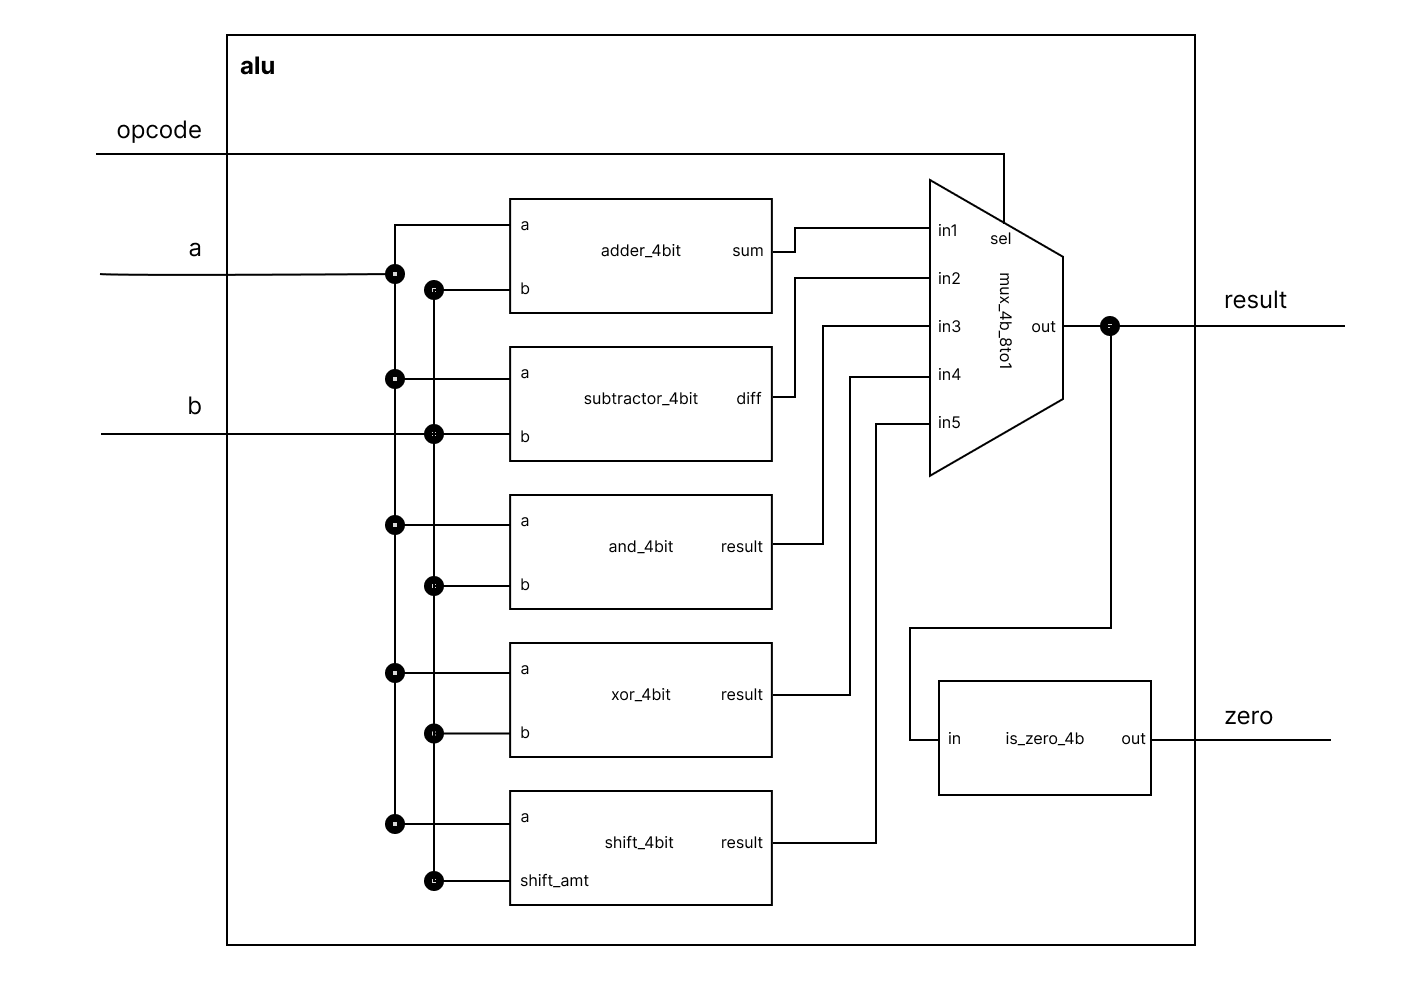

Fill in your verilog code below:

In [ ]:
%%writefile alu.v

module ALU (
    input [3:0] a, b,
    input [2:0] opcode,
    output [3:0] result,
    output zero
);

    // TODO: Do your stuff!

endmodule

# Checking

Press the ▷ button to check your work

In [ ]:
%cd content
! iverilog tb_alu.v alu.v components.v
! ./a.out